In [1]:
from Bio import SeqIO
import phylopandas as ph
import numpy as np
import pandas as pd
from Bio.SwissProt import KeyWList
from goatools.semantic import semantic_similarity


import re
import networkx
import obonet

from sklearn import linear_model
VECTOR_LEN=344
MAST_LEN=31

In [2]:
final_id = []
final_seq = []
final_term = []
with open('seq_file_31.txt','r') as file:
    for line in file:
        final_seq.append(line.strip())
with open('id_file_31.txt','r') as file:
    for line in file:
        final_id.append(line.strip())
with open('term_file_31.txt','r') as file:
    for line in file:
        final_term.append(line.strip())

In [3]:
terms=[]
for i in final_term:    
    m = re.sub('[\[\]\.\s]', '', i)
    terms.append(m)

In [10]:
rows = 0
cols = 0
X = [[0 for v in range(343)] for j in range(len(final_seq))]

for line in final_seq:
    st = []
    new_l = []
    s = ''

    st = re.sub('[\[\]\,]|', '', line)
   
    new_l = st.split(' ')
    for line1 in new_l[1:]:
        X[rows][cols] = int(float(line1))
        cols += 1
    rows += 1
    cols = 0

In [11]:
arr_int = []
for i in terms:
    arr_int.append(float(int(i,2)))
            

In [12]:
x_train, x_validate, x_test = np.split(X, [int(.7*len(X)), int(.9*len(X))])

In [13]:
y_train, y_validate, y_test = np.split(arr_int, [int(.7*len(arr_int)), int(.9*len(arr_int))])

In [8]:
b=list(np.where(y_train == 0)[0])
a=list(np.where(y_validate == 0)[0])
c=list(np.where(y_test == 0)[0])
ids=a+b+c


In [9]:
for i in ids:
    del terms[i]
    del final_seq[i]
    del final_id[i]

In [14]:
Y=terms.copy()

In [25]:
Y_train, Y_validate, Y_test = np.split(Y, [int(.7*len(Y)), int(.9*len(Y))])

In [67]:
%%time

reg_model_fit = linear_model.LinearRegression(fit_intercept=True,normalize=False)
reg_model_fit.fit(x_train,y_train)

CPU times: user 12.5 s, sys: 2.73 s, total: 15.2 s
Wall time: 5.23 s


/home/varvara/snap/jupyter/common/lib/python3.7/site-packages/scipy/linalg/basic.py:1231: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)


In [93]:
pred_fit = reg_model_fit.predict(x_validate)

In [94]:
pred_test = reg_model_fit.predict(x_test)


In [15]:
tobin = lambda x, count=8: "".join(map(lambda y:str((x>>y)&1), range(count-1, -1, -1)))

In [96]:
pred_y_valid_fit=[]
for i in pred_fit:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
#     if ln==32:
#         print(i)
    pred_y_valid_fit.append(num_bin)

In [103]:
pred_y_test_fit=[]
for i in pred_test:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_test_fit.append(num_bin)

In [104]:
Y_test[0]

'0000000000000000000000000111000010000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000101000000000000000'

In [105]:
pred_y_test_fit[0]

'0000000111001010001001100001100101000111111001000110010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

In [106]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_test))):
    numM=my_metrics(Y_test[i],pred_y_test_fit[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 13954/13954 [00:51<00:00, 269.97it/s]


In [107]:
xx = sum(metr)
print(xx/(len(metr)))
print(xx)

0.6427714144016113
8961.519059587265


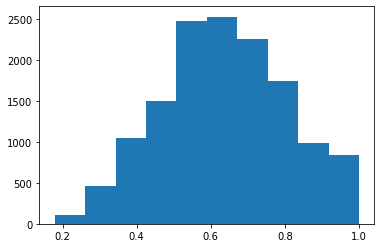

In [108]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [109]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_validate))):
    numM=my_metrics(Y_validate[i],pred_y_valid_fit[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 27906/27906 [01:43<00:00, 269.64it/s]


In [110]:
xx = sum(metr)
print(xx/(len(metr)))
print(xx)

0.6439325982079571
17963.14375960917


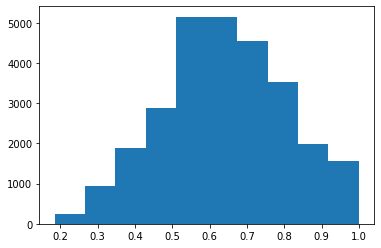

In [111]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [112]:
from sklearn.linear_model import Ridge

random_forest = Ridge(fit_intercept = False)
random_forest.fit(x_train, y_train) 

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [113]:
pred_v_rr = random_forest.predict(x_validate)

In [114]:
pred_t_rr = random_forest.predict(x_test)

In [115]:
pred_y_valid_rr=[]
for i in pred_v_rr:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_valid_rr.append(num_bin)

In [116]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_validate))):
    numM=my_metrics(Y_validate[i],pred_y_valid_rr[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 27906/27906 [01:45<00:00, 265.12it/s]


In [117]:
xx = sum(metr)
print(xx/(len(metr)))
print(xx)

0.6423380449145801
17918.662100937127


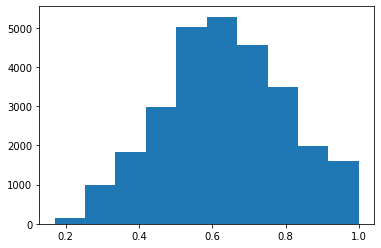

In [118]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [119]:
pred_y_t_rr=[]
for i in pred_t_rr:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_t_rr.append(num_bin)

In [120]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_test))):
    numM=my_metrics(Y_test[i],pred_y_t_rr[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 13954/13954 [00:54<00:00, 255.54it/s]


In [121]:
xx = sum(metr)
print(xx/(len(metr)))
print(xx)

0.642412171169962
8956.51049045161


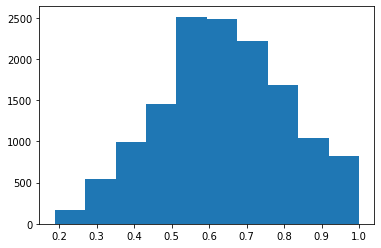

In [122]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [123]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)

In [124]:
regr_1.fit(x_train, y_train)
regr_2.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [131]:
y_1 = regr_1.predict(x_test)
y_2 = regr_2.predict(x_test)

In [132]:
pred_y_t_reg_1=[]
for i in y_1:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_t_reg_1.append(num_bin)

In [133]:
pred_y_t_reg_2=[]
for i in y_2:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_t_reg_2.append(num_bin)

In [134]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_test))):
    numM=my_metrics(Y_test[i],pred_y_t_reg_2[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 13954/13954 [00:52<00:00, 266.29it/s]


In [135]:
xx = sum(metr)
print(xx/(len(metr)))
print(xx)

0.6346702961259332
8848.573268587761


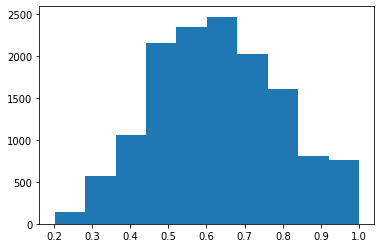

In [136]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [137]:
%%time
from sklearn.neighbors import KNeighborsRegressor
kneighbor_regression = KNeighborsRegressor(n_neighbors=5,n_jobs=-1,weights='distance')
kneighbor_regression.fit(x_train, y_train)

CPU times: user 7.95 s, sys: 208 ms, total: 8.15 s
Wall time: 8.13 s


In [138]:
%%time
y_pred_val= kneighbor_regression.predict(x_validate)

CPU times: user 29min 27s, sys: 487 ms, total: 29min 28s
Wall time: 29min 29s


In [139]:
%%time
y_pred_test= kneighbor_regression.predict(x_test)

CPU times: user 14min 13s, sys: 39.2 ms, total: 14min 13s
Wall time: 14min 13s


In [140]:
y_pred_val111=list(np.where(y_pred_test == 0.0)[0])

In [141]:
y_pred_val

array([4.05227060e+177, 4.05227015e+177, 4.66819225e+177, ...,
       5.88567791e+183, 5.07447819e+177, 4.05227433e+177])

In [196]:

pred_fit_valid_y_num_file = open('pred_fit_test_y_num_knn.txt','w')
for line in y_pred_val:
    pred_fit_valid_y_num_file.write(str(int(line))+'\n')    
pred_fit_valid_y_num_file.close()

In [142]:
pred_y_valid_fit_knn=[]
for i in y_pred_val:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_valid_fit_knn.append(num_bin)

In [143]:
pred_y_test_fit_knn=[]
for i in y_pred_test:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_test_fit_knn.append(num_bin)

In [144]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_test))):
    numM=my_metrics(Y_test[i],pred_y_test_fit_knn[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 13954/13954 [00:41<00:00, 336.50it/s]


In [145]:
xx = 0.0
for i in range(len(metr)):
    if metr[i] == 1000000:
        print(i)
    else:
        xx = xx + metr[i]
print(xx/(len(metr)))
print(xx)

0.6359427006339416
8866.313132238414


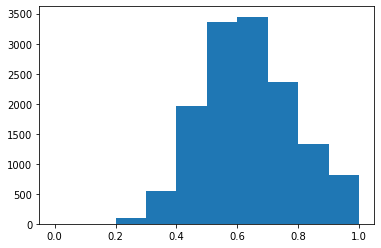

In [146]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [147]:
from tqdm import tqdm
metr_test = []
for i in tqdm(range(len(x_test))):
    metr_test.append(my_metrics(Y_test[i],pred_y_test_fit_knn[i]))

100%|██████████| 13954/13954 [00:41<00:00, 333.08it/s]


In [148]:
xx = 0.0
for i in range(len(metr_test)):
    if metr_test[i] == 1000000:
        print(i)
    else:
        xx = xx + metr_test[i]
print(xx/(len(metr_test)))
print(xx)

0.6345358414962315
8854.313132238414


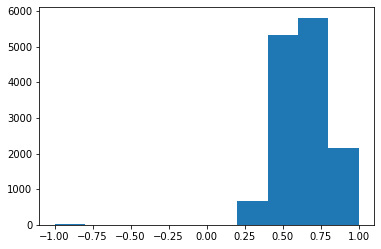

In [150]:
import matplotlib.pyplot as plt
plt.hist(metr_test)
plt.show()

In [156]:
import matplotlib.pyplot as plt
plt.hist(metr_test,100)
plt.show()

NameError: name 'metr_test' is not defined

In [157]:
%%time
from sklearn.linear_model import Ridge

random_forest = Ridge(fit_intercept = False)
random_forest.fit(x_train, y_train) 

CPU times: user 1.03 s, sys: 236 ms, total: 1.27 s
Wall time: 590 ms


In [110]:
pred_no_fit = reg_model_fit.predict(x_validate)

In [21]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [30]:
pred_v_reg = regr.predict(x_validate)

In [31]:
pred_y_valid_fit_rf=[]
for i in pred_v_reg:
    num_bin=tobin(int(i),MAST_LEN)
    ln=len(num_bin)
    if ln<MAST_LEN:
        for j in range(MAST_LEN-ln):
            num_bin='0'+num_bin
    pred_y_valid_fit_rf.append(num_bin)

In [32]:
from tqdm import tqdm
metr = []
cmns=0
for i in tqdm(range(len(x_validate))):
    numM=my_metrics(Y_validate[i],pred_y_valid_fit_rf[i])
    if numM==-1:
        cmns+=1
    else:    
        metr.append(numM)

100%|██████████| 27906/27906 [00:19<00:00, 1468.12it/s]


In [33]:
xx = sum(metr)
print(xx/(len(metr)))
print(xx)

0.9382269170054546
26172.77807678416


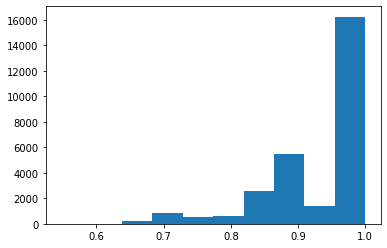

In [34]:
import matplotlib.pyplot as plt
plt.hist(metr)
plt.show()

In [19]:
import networkx as nx
graph = obonet.read_obo('http://purl.obolibrary.org/obo/go/go-basic.obo')

gProc = nx.DiGraph()
gComp = nx.DiGraph()
gFunc = nx.DiGraph()
for i, node in enumerate(graph.nodes):
    elem = graph.nodes[node]
    
    idName=node[3:]
    if idName == 'er_in_t':
        print('here')
    else:    
        if elem.get("namespace")=='cellular_component':
            gComp.add_node(idName)
        if elem.get("namespace")=='biological_process':
            gProc.add_node(idName)
        if elem.get("namespace")=='molecular_function':
            gFunc.add_node(idName)    
    if elem.get("is_a"):
        parent = elem.get("is_a")[0][3:]
        if elem.get("namespace")=='cellular_component':
            gComp.add_edge(idName,parent)
        if elem.get("namespace")=='biological_process':
            gProc.add_edge(idName,parent)
        if elem.get("namespace")=='molecular_function':
            gFunc.add_edge(idName,parent)

In [20]:
gFuncTemp = gFunc.copy()
print(gFuncTemp.number_of_nodes())
leaf = [x for x in gFuncTemp.nodes() if gFuncTemp.out_degree(x)!=0 and gFuncTemp.in_degree(x)==0]
gFuncTemp.remove_nodes_from(leaf)
gFuncCut1 = gFuncTemp.copy()
print(gFuncTemp.number_of_nodes())
leafTemp = [x for x in gFuncTemp.nodes() if gFuncTemp.out_degree(x)!=0 and gFuncTemp.in_degree(x)==0]
gFuncTemp.remove_nodes_from(leafTemp)
print(gFuncTemp.number_of_nodes())
leafTemp = [x for x in gFuncTemp.nodes() if gFuncTemp.out_degree(x)!=0 and gFuncTemp.in_degree(x)==0]
gFuncTemp.remove_nodes_from(leafTemp)
print(gFuncTemp.number_of_nodes())
leafTemp = [x for x in gFuncTemp.nodes() if gFuncTemp.out_degree(x)!=0 and gFuncTemp.in_degree(x)==0]
gFuncTemp.remove_nodes_from(leafTemp)
print(gFuncTemp.number_of_nodes())
leafTemp = [x for x in gFuncTemp.nodes() if gFuncTemp.out_degree(x)!=0 and gFuncTemp.in_degree(x)==0]
gFuncTemp.remove_nodes_from(leafTemp)
print(gFuncTemp.number_of_nodes())
leafTemp = [x for x in gFuncTemp.nodes() if gFuncTemp.out_degree(x)!=0 and gFuncTemp.in_degree(x)==0]
gFuncTemp.remove_nodes_from(leafTemp)
print(gFuncTemp.number_of_nodes())
print('--------------------------------------')
term_arr=list(gFuncTemp.nodes())
term_arr.sort()
TERM_VECTOR_LEN=len(term_arr)

11113
1711
616
264
125
64
31
--------------------------------------


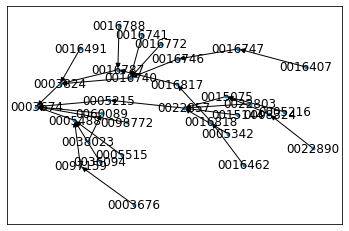

In [36]:
nx.draw_networkx(gFuncTemp, with_label = True, node_size=8) 


In [32]:
# def find_first_parents(id_name):
#     list_descendants = nx.descendants(gFunc, id_name)
# #     print(list_descendants)
#     return list_descendants

In [33]:
# def dist_in_tree(r,p):
#     if r == p:
#         return 0
#     id_real = term_arr[r]
#     id_pred = term_arr[p]
#     if id_real == '0003674':
#         return nx.shortest_path_length(gFunc,id_pred,id_real)
#     l1 = find_first_parents(id_real)
#     l2 = find_first_parents(id_pred) 
# #     print(l1)
# #     print(l2)
#     l3 = []
#     for line in l1:
#         for line1 in l2:
#             if line == line1:
#                 l3.append(line)
# #     print(l3)            
#     short_real = 10000000
#     parent_real = ''
#     for line in l3:
#         s1 = nx.shortest_path_length(gFunc,id_real,line)
#         if s1 < short_real:
#             short_real = s1
#             parent_real = line
#     short_pred = 10000000
#     parent_pred = ''
#     for line in l3:
#         s1 = nx.shortest_path_length(gFunc,id_pred,line)
#         if s1 < short_pred:
#             short_pred = s1
#             parent_pred = line
#     return max(short_pred,short_real)

In [27]:
# def my_metrics(expc_y,pred_y):
#     d = 1000000
#     s = 0
#     arr_d = []
#     for i in range(MAST_LEN):
#         if expc_y[i] == '1':
#             d = 1000000
#             for j in range(MAST_LEN):
#                 if expc_y[i] == pred_y[j]:
#                     s = dist_in_tree(i,j)
#                     if s < d:
#                         d = s
#             arr_d.append(d)
#     #print(arr_d)
#     summ = sum(arr_d)
#     real = expc_y.count('1')
#     pred = pred_y.count('1')
# #     if(real==0&pred==0):
# #         return 0
#     return summ/max(real,pred)

In [34]:
# def my_metrics(expc_y,pred_y):
#     valid=set()
#     for ind,i in enumerate(expc_y):
#          if i=='1':
#             ss=find_first_parents(term_arr[ind])
#             valid.update([term_arr[ind]])
#             valid.update(ss)
            
#     for ind,i in enumerate(pred_y):
#         if i=='1':
#             ss=find_first_parents(term_arr[ind])
#             pred.update([term_arr[ind]])
#             pred.update(ss)
            
#     if  max(len(valid),len(pred))==0:
#         return -1
#     else:
#         if len(valid)==0:
#             return -1
#         yyy=len(valid.difference(pred))
#         return yyy/(max(len(valid),len(pred)))        
        

In [16]:
def my_metrics(expc_y,pred_y):
    valid=set()
    arr_of_sims=[]
    for ind,i in enumerate(expc_y):
        min_sim=[]    
        if i=='1':
            for jnd,j in enumerate(pred_y):
                if j==i:
                    id_real = term_arr[ind]
                    id_pred = term_arr[jnd]
                    try:
                        sim = semantic_similarity('GO:'+id_real, 'GO:'+id_pred, godag)
#                         print(sim)
                    except Exception as e:
#                         print(e)
                        sim=0
                    min_sim.append(sim) 
#         if len(min_sim)==0:
#             return-1
            arr_of_sims.append(max(min_sim))  
    if len(arr_of_sims)==0:
        return -1
    return sum(arr_of_sims)/len(arr_of_sims)      
        

In [39]:

# valid=set()
# for ind,i in enumerate( Y_test[0]):
#     if i=='1':
#         ss=find_first_parents(term_arr[ind])
#         valid.update([term_arr[ind]])
#         valid.update(ss)
# #         for s in ss:
# #                 try:
# #                         valid.update(nx.ancestors(gFuncTemp, str(s)))
# #                 except Exception as e:
# #                     print("expe")
# #                     print(e)
        
# # pred=set()
# # for ind,i in enumerate(pred_y_test_fit[0]):
# #     if i=='1':
# #         pred.update(find_first_parents(term_arr[ind]))     
# # if  max(len(valid),len(pred))==0:
# #        print(-1)
# # else:
# #     if len(valid)==0:
# #           print(-1)
# # yyy=len(pred.difference(valid))
# # print( yyy/(max(len(valid),len(pred))))        


In [19]:
gFunc.number_of_edges('0003674', '0005488')
# nx.shortest_path_length(gFunc,'0097159', '0005488')

0

In [17]:
from goatools.obo_parser import GODag
godag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2020-03-23) 47,232 GO Terms


In [86]:
sim

0.5